Example notebook as part of my internship project in Spring 2021 at DHI GRAS about Volume Estimation of Supraglacial Lakes in Greenland.

In [97]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
from astropy.time import Time
import readers as rd
import os
from scipy.stats import norm, kurtosis
from scipy.optimize import curve_fit
import time
from sklearn.metrics import r2_score

Loading raw ICESat-2 ATL03 dataset

In [98]:
data_loc='E:/ATL03/' # update to where you downloaded the data
for file in os.listdir(data_loc):
    if file.startswith('processed_ATL03_20190814035453_07190403_003_01.h5') and file.endswith('.h5'):
        fname = file
print(fname)
f = h5py.File(data_loc+fname, 'r')
beam='gt3l'
dfATL03=rd.getATL03(f,beam)
dfATL03['AT_dist']=dfATL03.x-dfATL03.x.values[0]
dfATL03 = dfATL03.loc[(dfATL03["AT_dist"] > 5000) & (dfATL03["AT_dist"] < 10000)]
print("Photons in dataframe:", len(dfATL03))

processed_ATL03_20190814035453_07190403_003_01.h5
Photons in dataframe: 26897


Surf-function Estimates the surface of the icesheet/lakes. To find the depth of supraglacial lakes one must first define the surface of the lakes. Afterwards searches for photons below the surface to estimate depth of lake. 

In [121]:
def Surf(dfATL03, window_width):
    startTime = time.time()
    
    AT_dist_values = dfATL03['AT_dist'].values # Along Track Distance Values
    AT_dist_totmax = AT_dist_values.max()
    AT_dist_totmin = AT_dist_values.min()
    
    window_bed_width = 10

    heights_values = dfATL03['heights'].values

    lats = dfATL03['lats'].values
    lons = dfATL03['lons'].values
    
    windows = np.arange(AT_dist_totmin, AT_dist_totmax, 10).tolist()
    a = np.empty(len(windows))
    b = np.empty(len(windows))
    c = np.empty(len(windows))
    d = np.empty(len(windows))
    e = np.empty(len(windows))
    f = np.empty(len(windows))
    g = np.empty(len(windows))
    h = np.empty(len(windows))
    
    i = 0
    #Iterate through rows in dataframe
    for window_center in windows:    

        #---------------
        #Step 1: Window Boundries
        #---------------

        #Get minimum window boundries
        min_dist = window_center - window_width
        min_dist_array = np.where(AT_dist_values > min_dist)
        min_dist_row = min_dist_array[0][0]

        #Get maximum window boundries
        max_dist = window_center + window_width
        if max_dist < AT_dist_values[-1]:
            max_dist_array = np.where(AT_dist_values > max_dist)
            max_dist_row = max_dist_array[0][0]
        else:
            max_dist = AT_dist_values[-1] 

        #Get window center lat & long for plotting later        
        idx = (np.abs(AT_dist_values - window_center)).argmin()
        lat = lats[idx]
        lon = lons[idx]

        #Select photons AT_dist & heights within boundries
        window_AT_dist = AT_dist_values[min_dist_row:max_dist_row]    
        window_heights = heights_values[min_dist_row:max_dist_row]

        print("WC", window_center)
        print("min", window_AT_dist.min())
        print("max", window_AT_dist.max())

        w_len = len(window_heights)
        if w_len > window_width:
            #---------------
            #Step 2: Basic stats
            #---------------
            #Basic stats - mean & std
            mean = window_heights.mean()
            std = window_heights.std()

            #Polyfit to calulate slope
            coef = np.polyfit(window_AT_dist, window_heights, 1) 
            yfit = np.polyval(coef, window_AT_dist)
            residual = np.sum((window_heights-yfit)**2)
            slope = coef[0]
            threshold = window_width*20
            if residual > threshold:
                lakesurf = 1
            else:
                lakesurf = 0


            #------------------
            #Step 3: Find boundries of bins 
            #------------------

            #Parameters
            Dataset = window_heights
            binwidth = 0.2

            #Binning Data
            values, bins = np.histogram(Dataset, bins=np.arange(Dataset.min(), Dataset.max() + binwidth, binwidth))

            #Find mean of bin with highest count
            elem = np.argmax(values)
            maxbin = bins[elem]
            Lake_surf_mean = maxbin + (binwidth/2)
            Lake_surf_min = Lake_surf_mean - 0.5
            Lake_surf_max = Lake_surf_mean + 0.5

            #Slope of surf
            yval = [element for idx, element in enumerate(window_heights) if (element > Lake_surf_min) & (element < Lake_surf_max)]
            yindex = [idx for idx, element in enumerate(window_heights) if (element > Lake_surf_min) & (element < Lake_surf_max)]
            xval = [window_AT_dist[i1] for i1 in yindex]
            arr1 = np.array(yval)
            arr2 = np.array(xval)       

            coef1 = np.polyfit(arr2, arr1, 1) 
            yfit1 = np.polyval(coef1, arr2)
            residual1 = np.sum((arr1-yfit1)**2)
            slope3 = coef1[0]

            #Extract surface of lake
            Surf_heights = window_heights[(window_heights > Lake_surf_min) & (window_heights < Lake_surf_max)]
            Surf_heights_mean = Surf_heights.mean()
            
            #Bed_Heights
            #####
            #Get minimum window boundries
            min_dist_bed = window_center - window_bed_width - 1
            min_dist_bed_array = np.where(AT_dist_values > min_dist_bed)
            min_dist_bed_row = min_dist_bed_array[0][0]

            #Get maximum window boundries
            max_dist_bed = window_center + window_bed_width - 1
            if max_dist_bed < AT_dist_values[-1]:
                max_dist_bed_array = np.where(AT_dist_values > max_dist_bed)
                max_dist_bed_row = max_dist_bed_array[0][0]
            else:
                max_dist_bed = AT_dist_values[-1] 
                
            #Select photons AT_dist & heights within boundries
            window_AT_dist_bed = AT_dist_values[min_dist_bed_row:max_dist_bed_row]    
            window_heights_bed = heights_values[min_dist_bed_row:max_dist_bed_row]
            print("len whb",len(window_heights_bed))
            Bed_heights = window_heights_bed[window_heights_bed < Lake_surf_min - 1.5]
                     
            Bed_heights_std = Bed_heights.std()

            
            print("len bh",len(Bed_heights))
            if len(Bed_heights) > (window_bed_width*2):
#            Bed_heights = window_heights[window_heights < Lake_surf_min]
                Bed_heights_mean = Bed_heights.mean()            
                
                binwidth_bed = 0.5
                values_bed, bins_bed = np.histogram(Bed_heights, bins=np.arange(Bed_heights.min(), Bed_heights.max() + binwidth_bed, binwidth_bed))            

                elem_bed = np.argmax(values_bed)
                maxbin = bins_bed[elem_bed]
                Lake_bed_mean = maxbin + (binwidth_bed/2)
                Lake_bed_min = Lake_bed_mean - 2
                Lake_bed_max = Lake_bed_mean + 2

                Bed_heights2 = window_heights[(window_heights > Lake_bed_min) & (window_heights < Lake_bed_max)]
                Bed_heights_mean2 = Bed_heights2.mean()

                #Slope of bed
                yval_bed = [element for idx, element in enumerate(window_heights) if (element > Lake_bed_min) & (element < Lake_bed_max)]
                yindex_bed = [idx for idx, element in enumerate(window_heights) if (element > Lake_bed_min) & (element < Lake_bed_max)]
                xval_bed = [window_AT_dist[i2] for i2 in yindex_bed]

                arr1_bed = np.array(yval_bed)
                arr2_bed = np.array(xval_bed)
                print("min x", arr2_bed.min())
                print("max x", arr2_bed.max())
                  
                arr1_bed = np.array(yval_bed)
                arr2_bed = np.array(xval_bed)
                print("min x", arr2_bed.min())
                print("max x", arr2_bed.max())

                #Get minimum window boundries
                min_dist_bed = window_center - window_bed_width - 1
                min_dist_bed_array = np.where(AT_dist_values > min_dist_bed)
                min_dist_bed_row = min_dist_bed_array[0][0]

                #Get maximum window boundries
                max_dist_bed = window_center + window_bed_width - 1
                if max_dist_bed < AT_dist_values[-1]:
                    max_dist_bed_array = np.where(AT_dist_values > max_dist_bed)
                    max_dist_bed_row = max_dist_bed_array[0][0]
                else:
                    max_dist_bed = AT_dist_values[-1] 
                
                #Select photons AT_dist & heights within boundries
                window_AT_dist_bed = AT_dist_values[min_dist_bed_row:max_dist_bed_row]    
                window_heights_bed = heights_values[min_dist_bed_row:max_dist_bed_row]

                Bed_heights = window_heights_bed[window_heights_bed < Lake_surf_min]
            
            
                ##################################################################
            
            

                coef1_bed = np.polyfit(arr2_bed, arr1_bed, 1) 
                yfit1_bed = np.polyval(coef1_bed, arr2_bed)
                residual1_bed = np.sum((arr1_bed-yfit1_bed)**2)
                slope3_bed = coef1_bed[0]
                new_bed_mean = yfit1_bed.mean()

                depth = Surf_heights_mean - Bed_heights_mean
                depth_new = Surf_heights_mean - Lake_bed_mean
                depth_refraction = depth_new / 1.34
                diff = depth_new - depth_refraction
                real_lake_bed = Lake_bed_mean + diff

                print("Depth", Bed_heights_mean2)
                print("Depth new",new_bed_mean)

                #Photons Close To Mean
                print("mean", Surf_heights_mean)
            
            else:
                depth_refraction = -999
                real_lake_bed = 0
                Bed_heights_mean2 = 0
                Lake_bed_mean = 0

            #Photons
            Surf_photons = len(Surf_heights)
            Bed_photons = len(Bed_heights)

            #------------------
            #Step 4: Outputs
            #------------------

            a[i] = window_center
            b[i] = Bed_heights_std
            c[i] = Lake_surf_mean
            d[i] = lat
            e[i] = lon
            f[i] = depth_refraction
            g[i] = real_lake_bed
            h[i] = Lake_bed_mean
            
            i += 1
            
        else:
            i += 1

        wincen = int(window_center)
        if wincen % 5000 < 1:  
            m = int(i / len(windows) * 100)
            print(m, "% Done")
    
    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(a, columns = ['AT_dist']) 
    df["residual"] = b
    df["Surf_mean"] = c
    df["lats"] = d
    df["lons"] = e
    df["depth"] = f
    df["bed"] = g
    df["bed_new"] = h
    

    
    # Script Runtime
    runTime =  int(time.time() - startTime)
    runTimeMin = runTime/60
    runTimeSec = runTime%60
    print("\nScript Runtime: %i minutes and %i seconds" % (runTimeMin,runTimeSec))
    
    return df


Example of a supraglacial lake. red=Surface, Blue=Lakebed, Orange=Lakebed corrected

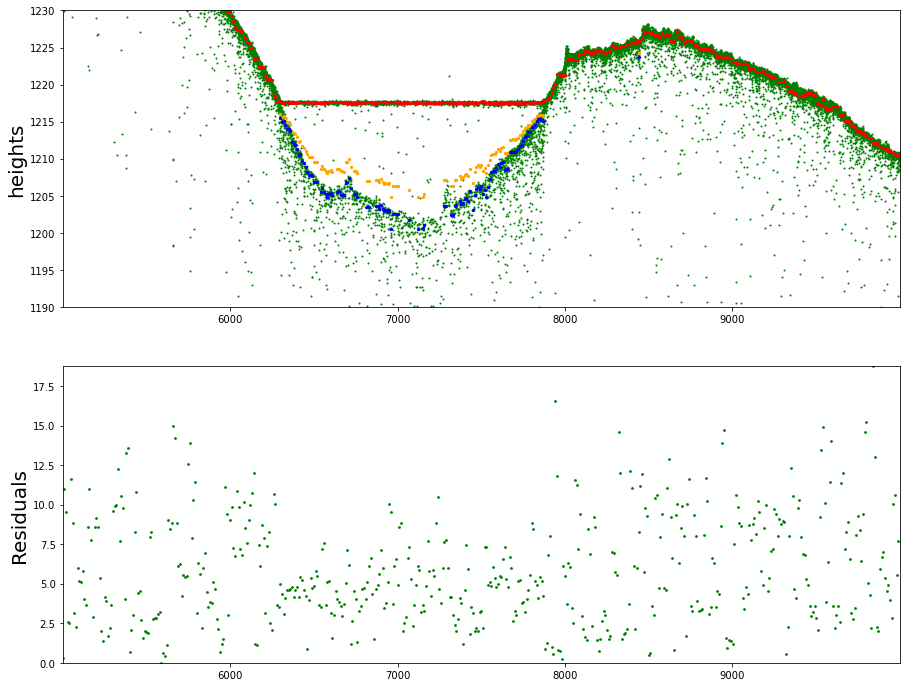

In [126]:
fig,ax=plt.subplots(2,1,figsize=(15,12))

y1 = 'heights'
y2 = 'residual'

minVal1, maxVal1 = dfATL03[y1].min(skipna=True), dfATL03[y1].max()
ax[0].scatter(dfATL03.AT_dist.values,dfATL03.heights.values,c='g',s=1)
ax[0].scatter(df.AT_dist.values,df.Surf_mean.values,c='r',s=5)
ax[0].scatter(df.AT_dist.values,df.bed.values,c='orange',s=5)
ax[0].scatter(df.AT_dist.values,df.bed_new.values,c='b',s=5)
ax[0].set_ylabel(y1,fontsize=20)
ax[0].set_ylim(1190, 1230);
ax[0].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal2, maxVal2 = df[y2].min(skipna=True), df[y2].max()
ax[1].scatter(df.AT_dist.values,df.residual.values,c='g',s=3)
ax[1].set_ylabel("Residuals",fontsize=20)
ax[1].set_ylim(minVal2, maxVal2);
ax[1].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);


Lake_Surf-function classifies lakes by looking at the flatness of the surface

In [105]:
def Lake_Surf(df_Surf, window_width):

    startTime = time.time()
    
    AT_dist_values = df_Surf['AT_dist'].values # Along Track Distance Values
    AT_dist_totmax = AT_dist_values.max()
    AT_dist_totmin = AT_dist_values.min()
    Residual_values = df_Surf['residual'].values
    Surf_values = df_Surf['Surf_mean'].values
    lats = df_Surf['lats'].values
    lons = df_Surf['lons'].values
    depth_surf = df_Surf['depth'].values

    
    windows = np.arange(AT_dist_totmin, AT_dist_totmax, 10).tolist()
    a = np.empty(len(windows))
    b = np.empty(len(windows))
    c = np.empty(len(windows))
    d = np.empty(len(windows))
    e = np.empty(len(windows))
    f = np.empty(len(windows))
    
    i = 0
    #Iterate through rows in dataframe
    for window_center in windows:    
        #---------------
        #Step 1: Window Boundries
        #---------------

        #Get minimum window boundries
        min_dist = window_center - window_width
        min_dist_array = np.where(AT_dist_values > min_dist)
        min_dist_row = min_dist_array[0][0]

        #Get maximum window boundries
        max_dist = window_center + window_width
        if max_dist < AT_dist_values[-1]:
            max_dist_array = np.where(AT_dist_values > max_dist)
            max_dist_row = max_dist_array[0][0]
        else:
            max_dist = AT_dist_values[-1] 

        #Select photons AT_dist & heights within boundries
        window_AT_dist = AT_dist_values[min_dist_row:max_dist_row]    
        window_heights = Surf_values[min_dist_row:max_dist_row]
        std1 = window_heights.std()
        print("std", std1)
        
        w_len = len(window_heights)
        print("wlen",w_len)
        if w_len > (window_width/6):
            res = Residual_values[i]
            lat = lats[i]
            lon = lons[i]
            depth = depth_surf[i]
            print("wc",window_center)
            print("res",res)
        
        #---------------
        #Step 2: Basic stats
        #---------------
        #Basic stats - mean & std
            std = window_heights.std()
            if (std < 0.1) & (res > 1):
                lakesurf = 1
            else:
                lakesurf = 0

            #------------------
            #Step 3: Outputs
            #------------------

            a[i] = window_center
            b[i] = lakesurf
            c[i] = std
            d[i] = lat
            e[i] = lon
            f[i] = depth
            #    e[i] = slope85
            i += 1
        else: 
            i += 1
        wincen = int(window_center)
        if wincen % 1000 < 1:  
            m = int(i / len(windows) * 100)
            print(m, "% Done")

    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(a, columns = ['AT_dist']) 
    df["lakesurf"] = b
    df["std1"] = c
    df["lat"] = d
    df["lon"] = e
    df["depth"] = f
    
#    df["slope"] = d

    # Script Runtime
    runTime =  int(time.time() - startTime)
    runTimeMin = runTime/60
    runTimeSec = runTime%60
    print("\nScript Runtime: %i minutes and %i seconds" % (runTimeMin,runTimeSec))
    
    return df

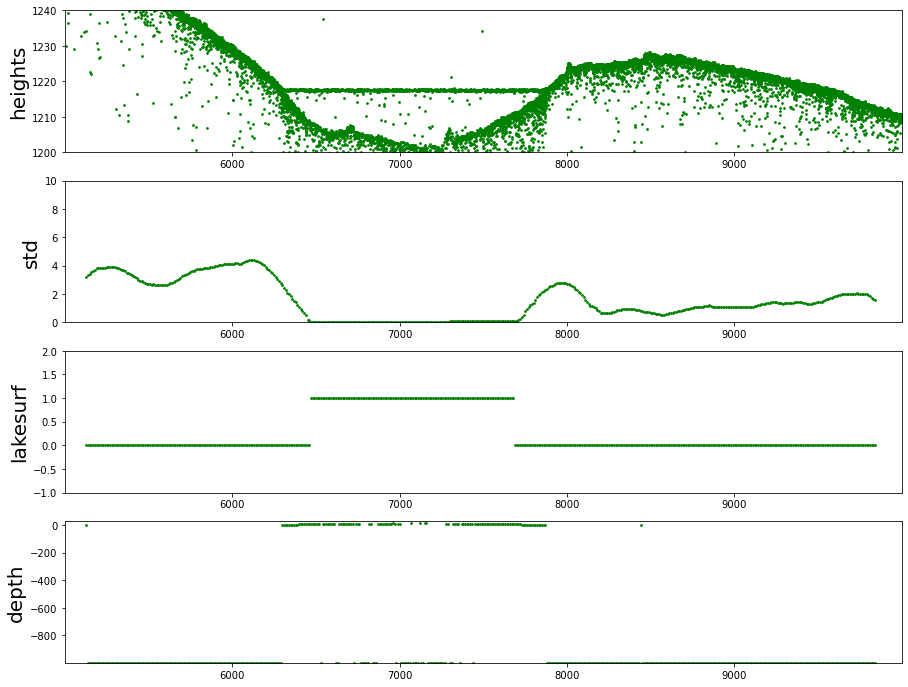

In [109]:
fig,ax=plt.subplots(4,1,figsize=(15,12))

y1 = 'heights'
y2 = 'std1'
y3 = 'lakesurf'
y4 = 'depth'
minVal1, maxVal1 = dfATL03[y1].min(skipna=True), dfATL03[y1].max()
ax[0].scatter(dfATL03.AT_dist.values,dfATL03.heights.values,c='g',s=3)
ax[0].scatter(df2.AT_dist.values,df2.lakesurf.values,c='r',s=3)
ax[0].set_ylabel(y1,fontsize=20)
ax[0].set_ylim(1200, 1240);
ax[0].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal2, maxVal2 = df2[y2].min(skipna=True), df2[y2].max()
ax[1].scatter(df2.AT_dist.values,df2.std1.values,c='g',s=3)
ax[1].set_ylabel("std",fontsize=20)
ax[1].set_ylim(0, 10);
ax[1].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal3, maxVal3 = df2[y3].min(skipna=True), df2[y3].max()
ax[2].scatter(df2.AT_dist.values,df2.lakesurf.values,c='g',s=3)
ax[2].set_ylabel("lakesurf",fontsize=20)
ax[2].set_ylim(-1, 2);
ax[2].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal4, maxVal4 = df2[y4].min(skipna=True), df2[y3].max()
ax[3].scatter(df2.AT_dist.values,df2.depth.values,c='g',s=3)
ax[3].set_ylabel("depth",fontsize=20)
ax[3].set_ylim(minVal4, 30);
ax[3].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);


Lake_Surf_Edge-function insures that the depth at the edges of supraglacial lakes are also calculated. 

In [111]:
def Lake_Surf_Edge(df_Lake_Surf, window_width):
    
    AT_dist_values = df_Lake_Surf['AT_dist'].values
    AT_dist_values = AT_dist_values.astype(int)
    Surf_search = df_Lake_Surf['lakesurf'].values
    lats = df_Lake_Surf['lat'].values
    lons = df_Lake_Surf['lon'].values
    depth_lake_surf = df_Lake_Surf['depth'].values
    
    AT_dist_totmax = AT_dist_values.max()
    print("max:",AT_dist_totmax)
    AT_dist_totmin = AT_dist_values.min()
    windows = np.arange(AT_dist_totmin, AT_dist_totmax, 10).tolist()
    i = 0
    
    a = np.empty(len(windows))
    b = np.empty(len(windows))
    c = np.empty(len(windows))
    d = np.empty(len(windows))
    f = np.empty(len(windows))
    
    df_len = len(Surf_search)
    df_len2 = len(windows)
    print("len1", df_len)
    print("len2", df_len2)
    
    
    for window_center in windows:
        
        if window_center < AT_dist_totmax:
            print("WC",window_center)
            #---------------
            #Step 1: Window Boundries
            #---------------

            #Get minimum window boundries
            min_dist = window_center - window_width
            min_dist_array = np.where(AT_dist_values > min_dist)
            min_dist_row = min_dist_array[0][0]

            #Get maximum window boundries
            max_dist = window_center + window_width
            if max_dist < AT_dist_values[-1]:
                max_dist_array = np.where(AT_dist_values > max_dist)
                max_dist_row = max_dist_array[0][0]
            else:
                max_dist = AT_dist_values[-1] 

            #Select photons AT_dist & heights within boundries
            window_AT_dist = AT_dist_values[min_dist_row:max_dist_row]    
    #        window_heights = Surf_values[min_dist_row:max_dist_row]
            window_surf = Surf_search[min_dist_row:max_dist_row]
        
            w_len = len(window_surf)
            print("wlen",w_len)
            print("at_dist", window_AT_dist)
            lake_search = 1 in window_surf
            lat = lats[i]
            lon = lons[i]
            depth = depth_lake_surf[i]
            print("i", i)
            print("lat i", lat)
            
            a[i] = window_center
            c[i] = lat
            d[i] = lon
            f[i] = depth
            
            if lake_search is True:
                lakesurfedge = 1
                b[i] = lakesurfedge
                i += 1
            else:
                lakesurfedge = 0
                b[i] = lakesurfedge
                i += 1

            wincen = int(window_center)
            if wincen % 1000 < 1:  
                m = int(i / len(windows) * 100)
                print(m, "% Done")

    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(a, columns = ['AT_dist']) 
    df["lakesurfedge"] = b
    df["lat"] = c
    df["lon"] = d
    df["depth"] = f
                  
    return df    

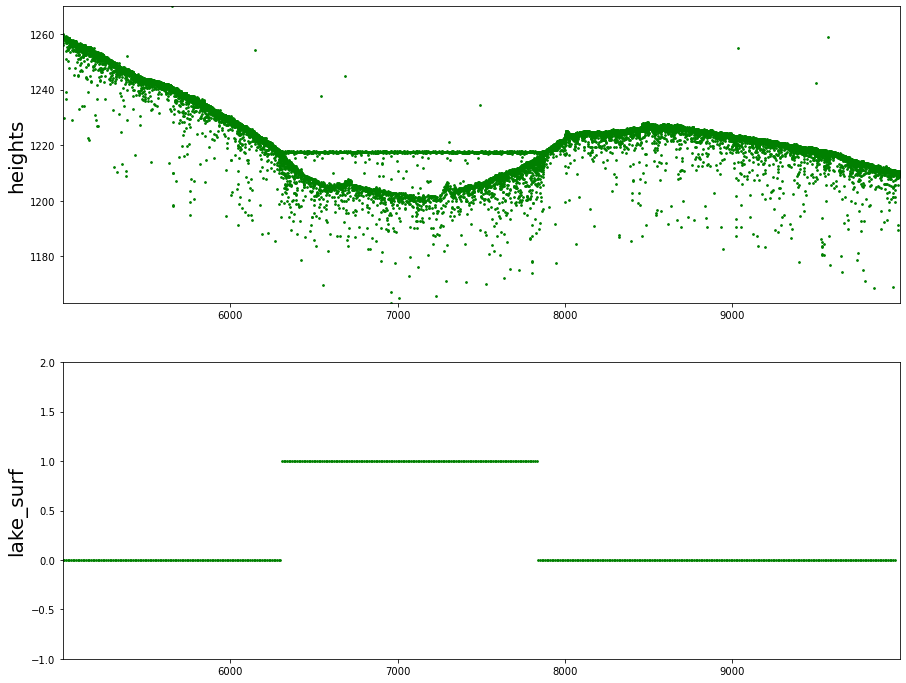

In [115]:
fig,ax=plt.subplots(2,1,figsize=(15,12))

y1 = 'heights'
y2 = 'lakesurfedge'
y3 = 'lakesurf'
minVal1, maxVal1 = dfATL03[y1].min(skipna=True), dfATL03[y1].max()
ax[0].scatter(dfATL03.AT_dist.values,dfATL03.heights.values,c='g',s=3)
ax[0].scatter(df.AT_dist.values,df.lakesurfedge.values,c='r',s=5)
ax[0].set_ylabel(y1,fontsize=20)
ax[0].set_ylim(minVal1, maxVal1);
ax[0].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal2, maxVal2 = df[y2].min(skipna=True), df[y2].max()
ax[1].scatter(df.AT_dist.values,df.lakesurfedge.values,c='g',s=3)
ax[1].set_ylabel("lake_surf",fontsize=20)
ax[1].set_ylim(-1, 2);
ax[1].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);


In [116]:
df5 = df3.loc[df3['lakesurfedge'] == 1]
df = df5.loc[df5['depth'] != -999]

In [117]:
from pyproj import Proj
pp = Proj(proj='utm',zone=22,ellps='WGS84', preserve_units=False)

xx, yy = pp(df["lon"].values, df["lat"].values)
df["X"] = xx
df["Y"] = yy 

In [118]:
from shapely.geometry import Point

# combine lat and lon column to a shapely Point() object
df['geometry'] = df.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)

In [119]:
import geopandas
df = geopandas.GeoDataFrame(df, geometry='geometry')

Output is used as training data in regression analysis with optical imagery

In [120]:
df.to_file('Geometry.shp', driver='ESRI Shapefile')